In [1]:
import PyPlot; const plt = PyPlot
using ProgressMeter
using FileIO
using Logging
include("./DQMC.jl")
include("./KinecticReader.jl")
# using .DQMC
import Statistics

const dtype = ComplexF64

function SsqureObs(x::DQMCWalker, scheme)
    sum = 0
    for i in 1:scheme.Nsite
        sum += 2*(1 - x.glTemp[i, i]) * x.glTemp[i, i]
    end
    return 0.75 * sum / scheme.Nsite
end

SsqureObs (generic function with 1 method)

In [2]:
debuglogger = ConsoleLogger(stderr, Logging.Info)
global_logger(debuglogger)

Base.CoreLogging.SimpleLogger(IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(46) open, 0 bytes waiting))), Info, Dict{Any, Int64}())

In [3]:
function ringS2QMC(beta, U, deltaTau, thermalizationTime, iterationTime)
    nx = 6
    ny = 1
    Δτ = deltaTau
    β = beta
    nflavor = 2

    # M, lattice length in imaginary time direction
    M = Int((β+0.01) ÷ Δτ)
    println(M)

#     thermalizationTime = 200
#     iterationTime = 10000
    # samplesPerIter = 20

    Nsites, Kinectic = BuildKinecticFromYAML("1dRingHamiltonian.yml", nx, ny, dtype)
    schemeSU2N = DQMCScheme{dtype}(Nsites, nflavor, M, Δτ, Kinectic)
    paramsAux = AuxFieldUpdaterParams{dtype}(U, schemeSU2N)
    x = initializeWalker(schemeSU2N, paramsAux);

    @showprogress for i in 1:thermalizationTime
        walkerMarkovMove!(x, paramsAux, schemeSU2N)
        # println()
    end

    s2 = Vector{dtype}(undef, iterationTime)

    @showprogress for i in 1:iterationTime
        walkerMarkovMove!(x, paramsAux, schemeSU2N)
        s2[i] = SsqureObs(x, schemeSU2N)
    end

    s2
end

ringS2QMC (generic function with 1 method)

In [ ]:
tau = 0.125
betas = [2, 3, 4, 5, 6, 7, 8, 12, 16, 32, 60] * tau
# betas = 1.0 ./ [2.4 + 0.1 * x for x in 1:11]
s2_list = []
s2_std_list = []
for beta in betas
    s2 = ringS2QMC(beta, 4.0, tau)
    append!(s2_list, Statistics.mean(real.(s2)))
    append!(s2_std_list, Statistics.std(real.(s2)) / sqrt(length(s2)))
end

In [34]:
# save("6siteRing_spin2_U=4.0_dtau=0.125.jld2", Dict("beta"=>betas, "sSquare_mean"=>s2_list, "sSquare_std"=>s2_std_list))
# save("6siteRing_spin2_U=4.0_dtau=0.125.jld2", x)

In [35]:
x = load("6siteRing_spin2_U=4.0_dtau=0.125.jld2")
y = load("6siteRing_spin2_U=4.0_ED.jld2")

Dict{String, Any} with 2 entries:
  "sSquare_mean" => Any[0.58347, 0.586659, 0.59357, 0.598725, 0.600817, 0.60041…
  "beta"         => [10.0, 5.0, 3.33333, 2.5, 2.0, 1.66667, 1.42857, 1.25, 1.11…

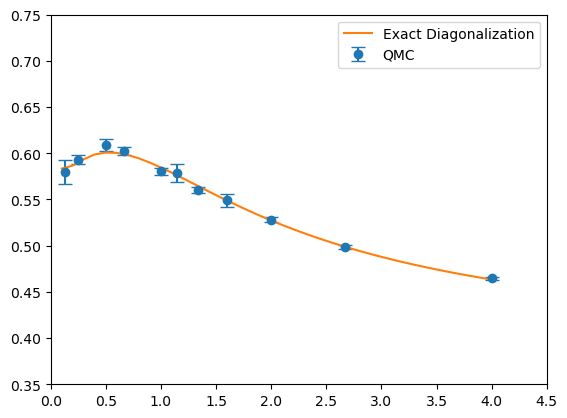

In [36]:
plt.errorbar(1.0 ./ x["beta"], x["sSquare_mean"], yerr=x["sSquare_std"], ls="none", marker="o", capsize=5, label="QMC")
plt.plot(1.0 ./ y["beta"], y["sSquare_mean"], label="Exact Diagonalization")
plt.ylim((0.35,0.75))
plt.xlim((0.0, 4.5))
plt.legend()
plt.show()

In [29]:
tau= 0.125
s2 = ringS2QMC(tau * 12, 4.0, tau, 1000, 50000);

12


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21


In [30]:
Statistics.mean(real.(s2)), Statistics.std(real.(s2)) / sqrt(length(s2))

(0.602784970083243, 0.004539833053834055)

In [31]:
x["sSquare_mean"][8] = Statistics.mean(real.(s2))
x["sSquare_std"][8] = Statistics.std(real.(s2)) / sqrt(length(s2))

0.004539833053834055